In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_process import ArmaProcess
from tqdm import tqdm_notebook
from itertools import product;
from typing import Union
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Veriyi düzgün şekilde yüklemek için ';' ile ayrılmış olduğunu belirteceğiz
data = pd.read_csv('bahcelievler.csv', sep=';')

# Sütun isimlerini düzenleyelim
data.columns = ['date', 'PM10', 'PM2.5', 'NO2']

# Tarih sütununu datetime formatına çevirelim
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

In [3]:
data.head()

,date,PM10,PM2.5,NO2
0,2015-01-01,"25,4","22,11","45,56"
1,2015-01-02,"22,04","6,98","35,85"
2,2015-01-03,"38,34","16,59","39,16"
3,2015-01-04,"20,6","9,59","30,91"
4,2015-01-05,"13,68","22,11","43,19"


In [4]:
data.set_index('date', inplace=True)

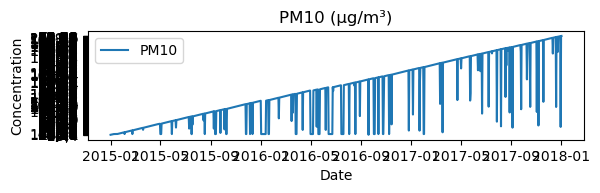

In [5]:
plt.subplot(3, 1, 1)
plt.plot(data.index, data['PM10'], label='PM10')
plt.title('PM10 (µg/m³)')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()


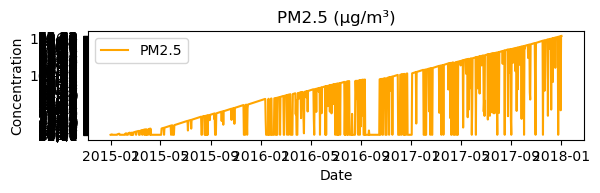

In [7]:
plt.subplot(3, 1, 2)
plt.plot(data.index, data['PM2.5'], label='PM2.5', color='orange')
plt.title('PM2.5 (µg/m³)')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()

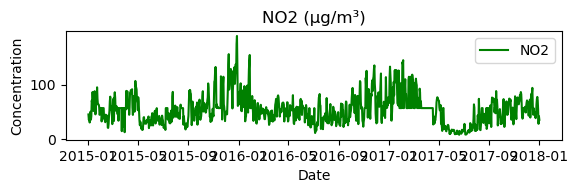

In [12]:
plt.subplot(3, 1, 3)
plt.plot(data.index, data['NO2'], label='NO2', color='green')
plt.title('NO2 (µg/m³)')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()

In [13]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.")
    else:
        print("Weak evidence against the null hypothesis, time series has a unit root, indicating it is non-stationary.")

In [14]:
# PM10 için ADF Testi
adf_test(data['PM10'], title='PM10')


Augmented Dickey-Fuller Test: PM10
ADF Test Statistic            -5.724771e+00
p-value                        6.811249e-07
#Lags Used                     1.300000e+01
Number of Observations Used    1.083000e+03
Critical Value (1%)           -3.436403e+00
Critical Value (5%)           -2.864212e+00
Critical Value (10%)          -2.568193e+00
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.


In [15]:
# PM2.5 için ADF Testi
adf_test(data['PM2.5'], title='PM2.5')

Augmented Dickey-Fuller Test: PM2.5
ADF Test Statistic               -3.886604
p-value                           0.002136
#Lags Used                       15.000000
Number of Observations Used    1081.000000
Critical Value (1%)              -3.436414
Critical Value (5%)              -2.864217
Critical Value (10%)             -2.568196
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.


In [16]:
# NO2 için ADF Testi
adf_test(data['NO2'], title='NO2')

Augmented Dickey-Fuller Test: NO2
ADF Test Statistic               -3.340147
p-value                           0.013177
#Lags Used                       14.000000
Number of Observations Used    1082.000000
Critical Value (1%)              -3.436408
Critical Value (5%)              -2.864215
Critical Value (10%)             -2.568194
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary.


In [17]:
def plot_acf_pacf(series, lags=50):
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))

    # ACF grafiği
    plot_acf(series, lags=lags, ax=ax[0])
    ax[0].set_title('ACF')

    # PACF grafiği
    plot_pacf(series, lags=lags, ax=ax[1])
    ax[1].set_title('PACF')

    plt.show()

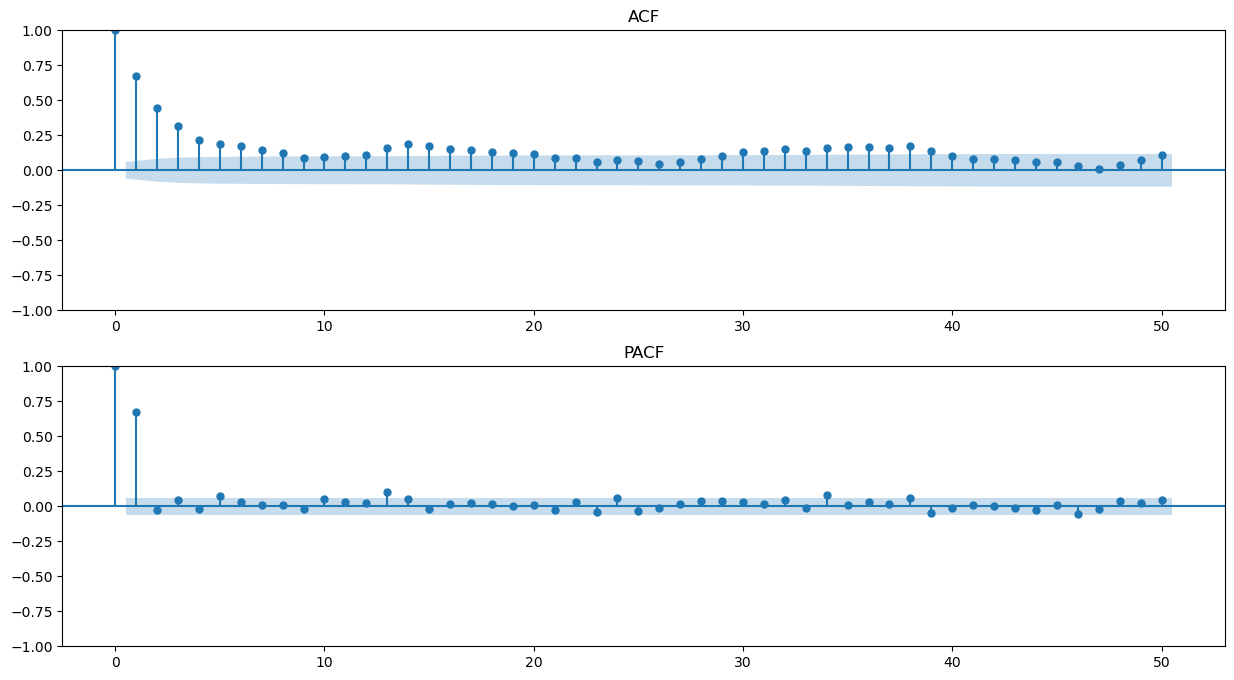

In [18]:
plot_acf_pacf(data['PM10'].dropna())

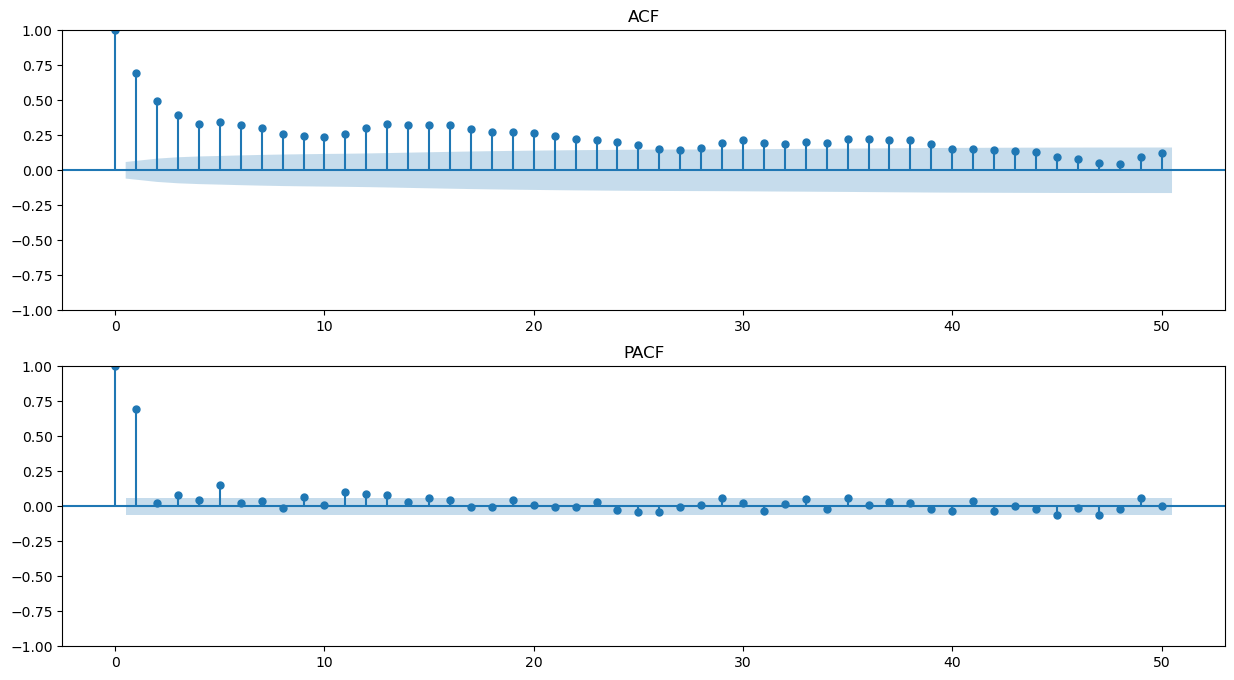

In [19]:
plot_acf_pacf(data['PM2.5'].dropna())


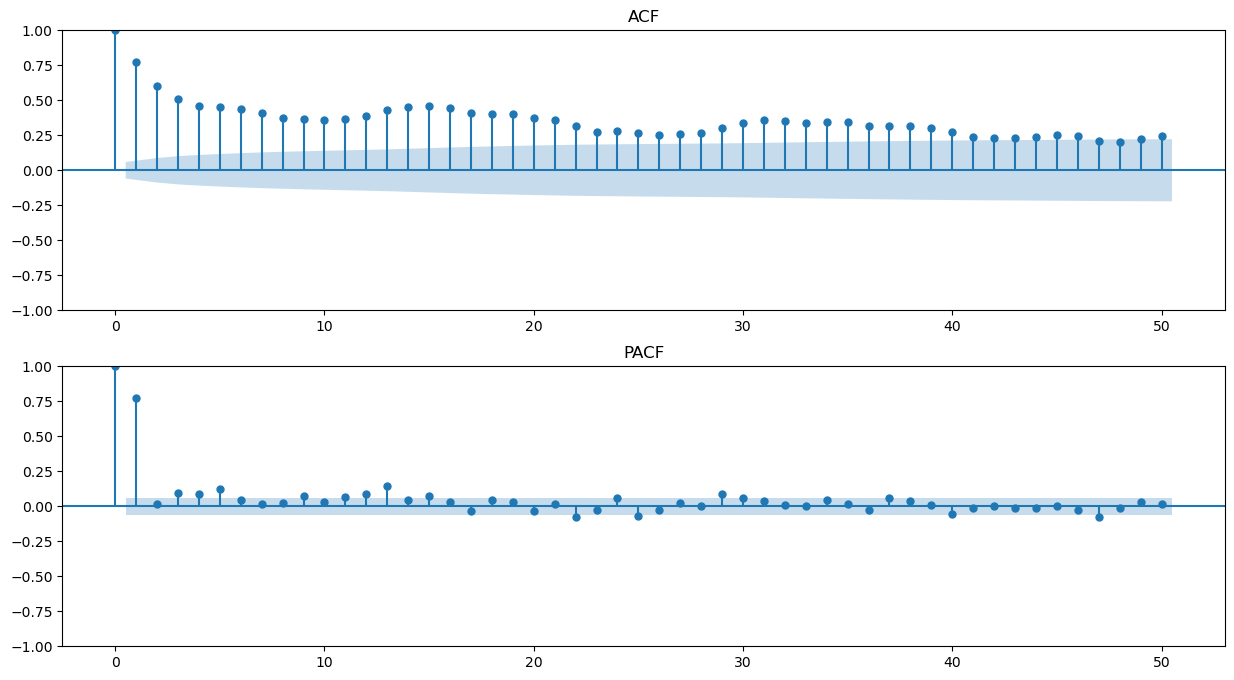

In [20]:
# NO2 için ACF ve PACF grafikleri
plot_acf_pacf(data['NO2'].dropna())

In [21]:
# Eksik değerleri kontrol etme
print(data.isnull().sum())

# Eksik değerleri ortalama ile doldurma
#df.fillna(df.mean(), inplace=True)

PM10     0
PM2.5    0
NO2      0
dtype: int64


In [22]:
## PM10 İÇİN BEST MODEL BULMA VE PERFORMANS ÖLÇME







In [23]:
def evaluate_arima_model(data, arima_order):
    model = ARIMA(data, order=arima_order)
    model_fitPM10 = model.fit()
    aic = model_fitPM10.aic
    bic = model_fitPM10.bic
    return aic, bic

p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                aic, bic = evaluate_arima_model(data['PM10'], order)
                if aic < best_score:
                    best_score, best_cfg = aic, order
                print(f'ARIMA{order} AIC={aic:.3f} BIC={bic:.3f}')
            except:
                continue

print(f'En iyi ARIMA model: ARIMA{best_cfg} AIC={best_score:.3f}')

ARIMA(0, 0, 0) AIC=10736.237 BIC=10746.237
ARIMA(0, 0, 1) AIC=10247.691 BIC=10262.692
ARIMA(0, 0, 2) AIC=10149.907 BIC=10169.908
ARIMA(0, 0, 3) AIC=10091.402 BIC=10116.404
ARIMA(0, 0, 4) AIC=10079.698 BIC=10109.700
ARIMA(0, 1, 0) AIC=10247.032 BIC=10252.031
ARIMA(0, 1, 1) AIC=10212.541 BIC=10222.540
ARIMA(0, 1, 2) AIC=10129.893 BIC=10144.891
ARIMA(0, 1, 3) AIC=10088.161 BIC=10108.158
ARIMA(0, 1, 4) AIC=10053.841 BIC=10078.839
ARIMA(0, 2, 0) AIC=11142.785 BIC=11147.784
ARIMA(0, 2, 1) AIC=10247.817 BIC=10257.814
ARIMA(0, 2, 2) AIC=10213.776 BIC=10228.772
ARIMA(0, 2, 3) AIC=10133.082 BIC=10153.076
ARIMA(0, 2, 4) AIC=10093.429 BIC=10118.422
ARIMA(1, 0, 0) AIC=10067.019 BIC=10082.020
ARIMA(1, 0, 1) AIC=10068.291 BIC=10088.292
ARIMA(1, 0, 2) AIC=10067.351 BIC=10092.352
ARIMA(1, 0, 3) AIC=10069.264 BIC=10099.266
ARIMA(1, 0, 4) AIC=10059.473 BIC=10094.476
ARIMA(1, 1, 0) AIC=10226.810 BIC=10236.809
ARIMA(1, 1, 1) AIC=10051.607 BIC=10066.605
ARIMA(1, 1, 2) AIC=10050.184 BIC=10070.182
ARIMA(1, 1,

In [24]:
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

train = data[:train_size]
val = data[train_size:train_size+val_size]
test = data[train_size+val_size:]

In [25]:
model = ARIMA(train['PM10'], order=(3, 1, 4))
model_fitPM10 = model.fit()

In [26]:
val_predictions = model_fitPM10.forecast(steps=len(val))
val_predictions = pd.Series(val_predictions, index=val.index)

if val['PM10'].isnull().values.any():
    val['PM10'] = val['PM10'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if val_predictions.isnull().values.any():
    val_predictions = val_predictions.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_val = mean_absolute_error(val['PM10'], val_predictions)
mse_val = mean_squared_error(val['PM10'], val_predictions)
rmse_val = np.sqrt(mse_val)

print(f'Validation MAE: {mae_val}')
print(f'Validation MSE: {mse_val}')
print(f'Validation RMSE: {rmse_val}')

Validation MAE: 22.816773130068878
Validation MSE: 980.0628712583991
Validation RMSE: 31.305955843232116


In [27]:
# Test seti üzerinde tahmin yapma
test_predictions = model_fitPM10.forecast(steps=len(test))
test_predictions = pd.Series(test_predictions, index=test.index)

# NaN değerleri kontrol etme ve doldurma
if test['PM10'].isnull().values.any():
    test['PM10'] = test['PM10'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if test_predictions.isnull().values.any():
    test_predictions = test_predictions.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_test = mean_absolute_error(test['PM10'], test_predictions)
mse_test = mean_squared_error(test['PM10'], test_predictions)
rmse_test = np.sqrt(mse_test)

print(f'Test MAE: {mae_test}')
print(f'Test MSE: {mse_test}')
print(f'Test RMSE: {rmse_test}')

Test MAE: 28.494124545626196
Test MSE: 1838.6824241556076
Test RMSE: 42.87986035606468


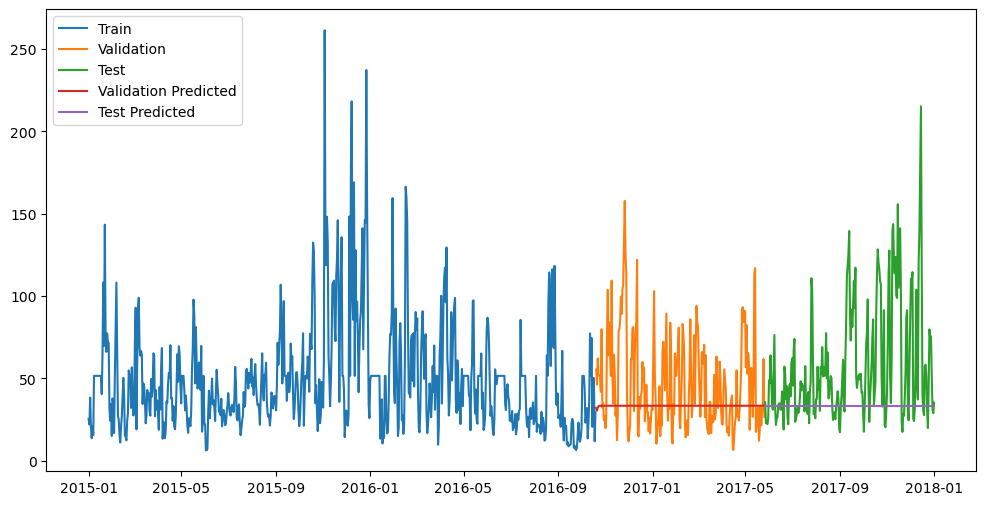

In [28]:
# Gerçek değerlerle tahmin edilen değerleri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train['PM10'], label='Train')
plt.plot(val['PM10'], label='Validation')
plt.plot(test['PM10'], label='Test')
plt.plot(val_predictions, label='Validation Predicted')
plt.plot(test_predictions, label='Test Predicted')
plt.legend()
plt.show()

In [29]:
best_modelPM10 = ARIMA(data['PM10'], order=(3, 1, 4))
model_fitPM10 = best_modelPM10.fit()

print(model_fitPM10.summary())

                               SARIMAX Results                                
Dep. Variable:                   PM10   No. Observations:                 1097
Model:                 ARIMA(3, 1, 4)   Log Likelihood               -5016.478
Date:                Tue, 11 Jun 2024   AIC                          10048.955
Time:                        21:47:13   BIC                          10088.951
Sample:                    01-01-2015   HQIC                         10064.089
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8024      0.044    -18.191      0.000      -0.889      -0.716
ar.L2         -0.1701      0.057     -2.986      0.003      -0.282      -0.058
ar.L3          0.5597      0.039     14.225      0.0

In [32]:
n_periods = 12  # 4 adım ileriye tahmin
forecast = model_fitPM10.forecast(steps=n_periods)
forecast

2018-01-02    48.500757
2018-01-03    58.946610
2018-01-04    58.447335
2018-01-05    64.909916
2018-01-06    65.655851
2018-01-07    63.678875
2018-01-08    68.755473
2018-01-09    65.435726
2018-01-10    66.129658
2018-01-11    68.978780
2018-01-12    64.716573
2018-01-13    68.040441
Freq: D, Name: predicted_mean, dtype: float64

In [33]:
# Güven aralıklarını hesaplama
conf_int = model_fitPM10.get_forecast(steps=n_periods).conf_int()

In [34]:
# Tahminleri DataFrame'e çevirme
forecast_index = pd.date_range(start=data.index[-1], periods=n_periods+1)
forecast_series = pd.Series(forecast, index=forecast_index)
lower_series = pd.Series(conf_int.iloc[:, 0], index=forecast_index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=forecast_index)

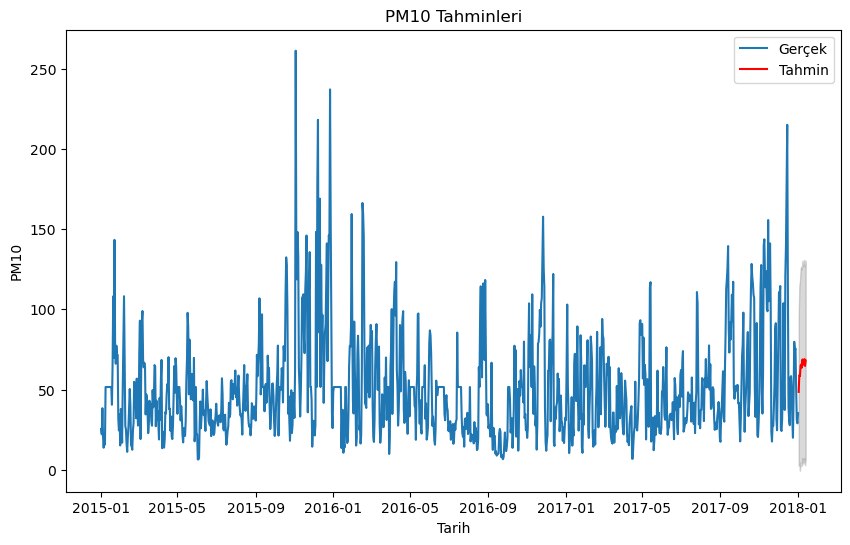

In [35]:
plt.figure(figsize=(10,6))
plt.plot(data.index, data['PM10'], label='Gerçek')
plt.plot(forecast_series.index, forecast_series, color='red', label='Tahmin')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.xlabel('Tarih')
plt.ylabel('PM10')
plt.title('PM10 Tahminleri')
plt.legend()
plt.show()

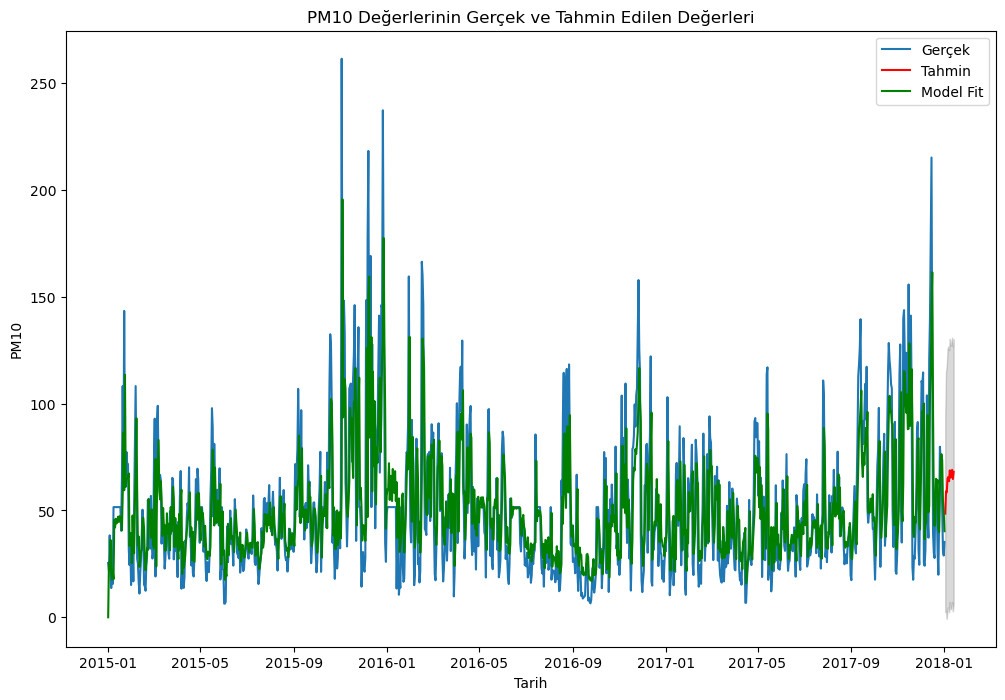

In [36]:
plt.figure(figsize=(12, 8))

plt.plot(data.index, data['PM10'], label='Gerçek')

# Model tarafından tahmin edilen veriler
plt.plot(forecast_series.index, forecast_series, color='red', label='Tahmin')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

# Modelin eğitildiği dönem için tahmin değerleri
fitted_values = model_fitPM10.fittedvalues
plt.plot(fitted_values.index, fitted_values, color='green', label='Model Fit')

plt.xlabel('Tarih')
plt.ylabel('PM10')
plt.title('PM10 Değerlerinin Gerçek ve Tahmin Edilen Değerleri')
plt.legend()
plt.show()

In [37]:
# PM2.5 İÇİN TÜM İLERLEMELER  





In [38]:
def evaluate_arima_modelPM25(data, arima_order):
    modelPM25 = ARIMA(data, order=arima_order)
    model_fitPM25 = modelPM25.fit()
    aic = model_fitPM25.aic
    bic = model_fitPM25.bic
    return aic, bic

p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 3)

best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                aic, bic = evaluate_arima_modelPM25(data['PM2.5'], order)
                if aic < best_score:
                    best_score, best_cfg = aic, order
                print(f'ARIMA{order} AIC={aic:.3f} BIC={bic:.3f}')
            except:
                continue

print(f'En iyi ARIMA model: ARIMA{best_cfg} AIC={best_score:.3f}')

ARIMA(0, 0, 0) AIC=8894.604 BIC=8904.604
ARIMA(0, 0, 1) AIC=8385.609 BIC=8400.610
ARIMA(0, 0, 2) AIC=8279.184 BIC=8299.185
ARIMA(0, 1, 0) AIC=8333.657 BIC=8338.656
ARIMA(0, 1, 1) AIC=8279.100 BIC=8289.099
ARIMA(0, 1, 2) AIC=8165.307 BIC=8180.306
ARIMA(0, 2, 0) AIC=9256.507 BIC=9261.506
ARIMA(0, 2, 1) AIC=8336.173 BIC=8346.170
ARIMA(0, 2, 2) AIC=8282.331 BIC=8297.327
ARIMA(0, 3, 0) AIC=10452.574 BIC=10457.572
ARIMA(0, 3, 1) AIC=9258.047 BIC=9268.042
ARIMA(0, 3, 2) AIC=8346.689 BIC=8361.682
ARIMA(1, 0, 0) AIC=8165.219 BIC=8180.220
ARIMA(1, 0, 1) AIC=8166.565 BIC=8186.566
ARIMA(1, 0, 2) AIC=8152.283 BIC=8177.285
ARIMA(1, 1, 0) AIC=8303.740 BIC=8313.739
ARIMA(1, 1, 1) AIC=8124.797 BIC=8139.795
ARIMA(1, 1, 2) AIC=8122.832 BIC=8142.830
ARIMA(1, 2, 0) AIC=8937.995 BIC=8947.992
ARIMA(1, 2, 1) AIC=8306.478 BIC=8321.474
ARIMA(1, 2, 2) AIC=8332.666 BIC=8352.660
ARIMA(1, 3, 0) AIC=9842.631 BIC=9852.626
ARIMA(1, 3, 1) AIC=8940.641 BIC=8955.633
ARIMA(1, 3, 2) AIC=8318.065 BIC=8338.055
ARIMA(2, 0, 0)

In [39]:
modelPM25 = ARIMA(train['PM2.5'], order=(2, 1, 2))
model_fitPM25 = modelPM25.fit()

In [40]:
val_predictionsPM25 = model_fitPM25.forecast(steps=len(val))
val_predictionsPM25 = pd.Series(val_predictionsPM25, index=val.index)

if val['PM2.5'].isnull().values.any():
    val['PM2.5'] = val['PM2.5'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if val_predictionsPM25.isnull().values.any():
    val_predictionsPM25 = val_predictionsPM25.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_valPM25 = mean_absolute_error(val['PM2.5'], val_predictionsPM25)
mse_valPM25 = mean_squared_error(val['PM2.5'], val_predictionsPM25)
rmse_valPM25 = np.sqrt(mse_valPM25)

print(f'Validation MAE: {mae_valPM25}')
print(f'Validation MSE: {mse_valPM25}')
print(f'Validation RMSE: {rmse_valPM25}')

Validation MAE: 10.724419235049272
Validation MSE: 300.3472263967498
Validation RMSE: 17.330528739676403


In [41]:
# Test seti üzerinde tahmin yapma
test_predictionsPM25 = model_fitPM25.forecast(steps=len(test))
test_predictionsPM25 = pd.Series(test_predictionsPM25, index=test.index)

# NaN değerleri kontrol etme ve doldurma
if test['PM2.5'].isnull().values.any():
    test['PM2.5'] = test['PM2.5'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if test_predictionsPM25.isnull().values.any():
    test_predictionsPM25 = test_predictionsPM25.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_testPM25 = mean_absolute_error(test['PM2.5'], test_predictionsPM25)
mse_testPM25 = mean_squared_error(test['PM2.5'], test_predictionsPM25)
rmse_testPM25 = np.sqrt(mse_testPM25)

print(f'Test MAE: {mae_testPM25}')
print(f'Test MSE: {mse_testPM25}')
print(f'Test RMSE: {rmse_testPM25}')

Test MAE: 10.10287883543035
Test MSE: 237.08678000233382
Test RMSE: 15.397622543832338


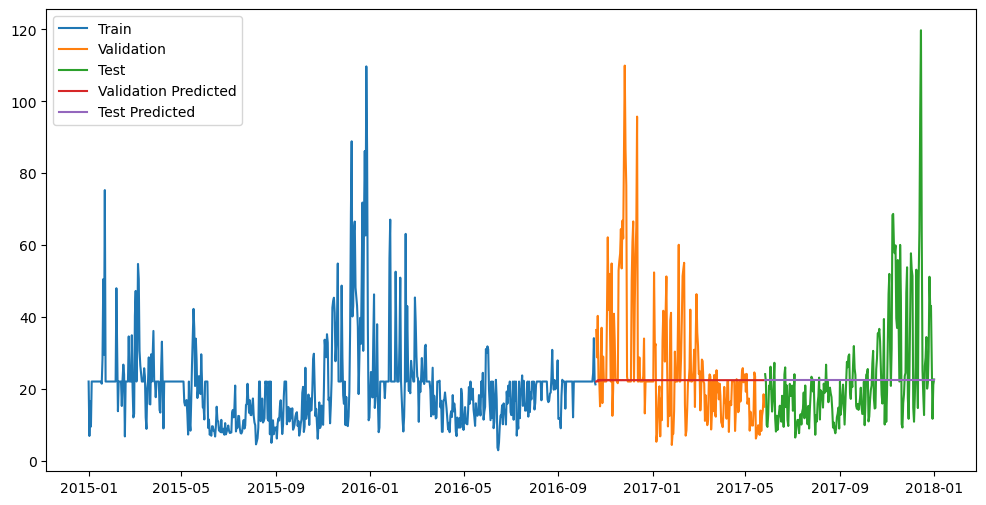

In [42]:
# Gerçek değerlerle tahmin edilen değerleri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train['PM2.5'], label='Train')
plt.plot(val['PM2.5'], label='Validation')
plt.plot(test['PM2.5'], label='Test')
plt.plot(val_predictionsPM25, label='Validation Predicted')
plt.plot(test_predictionsPM25, label='Test Predicted')
plt.legend()
plt.show()

In [43]:
best_modePM25 = ARIMA(data['PM2.5'], order=(3, 1, 2))
model_fitPM25 = best_modePM25.fit()
print(model_fitPM25.summary())      #BURADA OVERFİTTİNG DURUMU OLDUĞU İÇİN EN İYİ MODEL SEÇİMİ DEĞİŞİYOR

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1097
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -4051.848
Date:                Tue, 11 Jun 2024   AIC                           8115.697
Time:                        21:47:54   BIC                           8145.693
Sample:                    01-01-2015   HQIC                          8127.047
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3594      0.034    -10.519      0.000      -0.426      -0.292
ar.L2          0.4879      0.032     15.418      0.000       0.426       0.550
ar.L3         -0.0312      0.024     -1.303      0.1

In [44]:
n_periods = 12  # 4 adım ileriye tahmin
forecastPM25 = model_fitPM25.forecast(steps=n_periods)
forecastPM25

2018-01-02    28.648509
2018-01-03    30.139879
2018-01-04    32.470590
2018-01-05    32.174302
2018-01-06    33.371334
2018-01-07    32.723849
2018-01-08    33.549792
2018-01-09    32.899712
2018-01-10    33.556504
2018-01-11    32.977529
2018-01-12    33.526324
2018-01-13    33.026131
Freq: D, Name: predicted_mean, dtype: float64

In [45]:
# Güven aralıklarını hesaplama
conf_intPM25 = model_fitPM25.get_forecast(steps=n_periods).conf_int()

In [46]:
# Tahminleri DataFrame'e çevirme
forecast_indexPM25 = pd.date_range(start=data.index[-1], periods=n_periods+1)
forecast_seriesPM25 = pd.Series(forecastPM25, index=forecast_indexPM25)
lower_seriesPM25 = pd.Series(conf_intPM25.iloc[:, 0], index=forecast_indexPM25)
upper_seriesPM25 = pd.Series(conf_intPM25.iloc[:, 1], index=forecast_indexPM25)

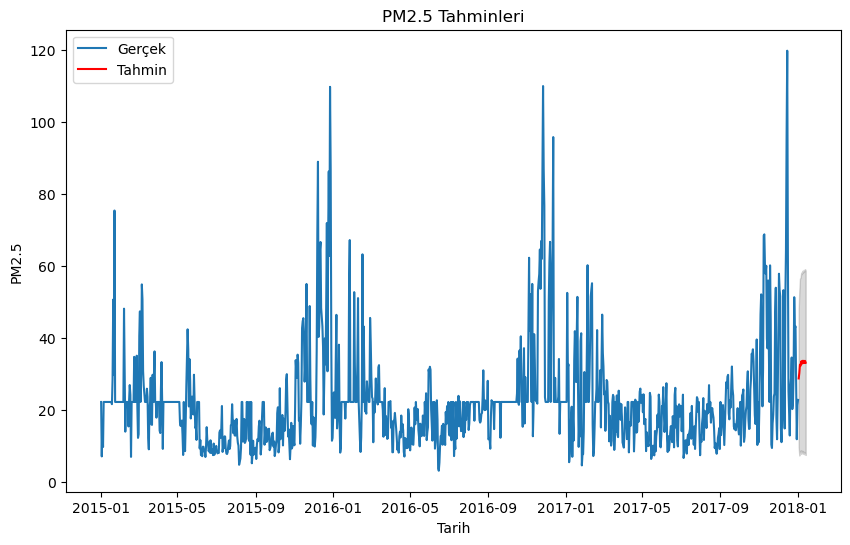

In [47]:
plt.figure(figsize=(10,6))
plt.plot(data.index, data['PM2.5'], label='Gerçek')
plt.plot(forecast_seriesPM25.index, forecast_seriesPM25, color='red', label='Tahmin')
plt.fill_between(lower_seriesPM25.index, 
                 lower_seriesPM25, 
                 upper_seriesPM25, 
                 color='k', alpha=.15)

plt.xlabel('Tarih')
plt.ylabel('PM2.5')
plt.title('PM2.5 Tahminleri')
plt.legend()
plt.show()

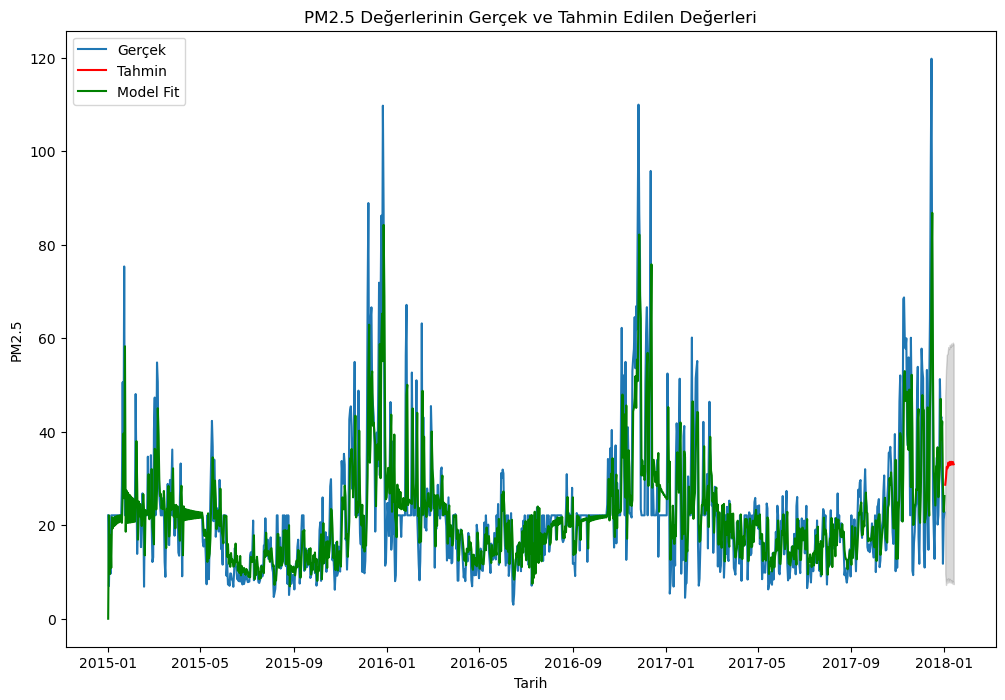

In [48]:
plt.figure(figsize=(12, 8))

plt.plot(data.index, data['PM2.5'], label='Gerçek')

# Model tarafından tahmin edilen veriler
plt.plot(forecast_seriesPM25.index, forecast_seriesPM25, color='red', label='Tahmin')
plt.fill_between(lower_seriesPM25.index, lower_seriesPM25, upper_seriesPM25, color='k', alpha=.15)

# Modelin eğitildiği dönem için tahmin değerleri
fitted_valuesPM25 = model_fitPM25.fittedvalues
plt.plot(fitted_valuesPM25.index, fitted_valuesPM25, color='green', label='Model Fit')

plt.xlabel('Tarih')
plt.ylabel('PM2.5')
plt.title('PM2.5 Değerlerinin Gerçek ve Tahmin Edilen Değerleri')
plt.legend()
plt.show()

In [49]:
# NO2 İÇİN TÜM İLERLEMELER  








In [50]:
def evaluate_arima_modelNO2(data, arima_order):
    model = ARIMA(data, order=arima_order)
    model_fitNO2 = model.fit()
    aic = model_fitNO2.aic
    bic = model_fitNO2.bic
    return aic, bic

p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                aic, bic = evaluate_arima_modelNO2(data['NO2'], order)
                if aic < best_score:
                    best_score, best_cfg = aic, order
                print(f'ARIMA{order} AIC={aic:.3f} BIC={bic:.3f}')
            except:
                continue

print(f'En iyi ARIMA model: ARIMA{best_cfg} AIC={best_score:.3f}')

ARIMA(0, 0, 0) AIC=10288.044 BIC=10298.044
ARIMA(0, 0, 1) AIC=9664.945 BIC=9679.946
ARIMA(0, 0, 2) AIC=9483.404 BIC=9503.405
ARIMA(0, 0, 3) AIC=9389.547 BIC=9414.548
ARIMA(0, 0, 4) AIC=9370.460 BIC=9400.462
ARIMA(0, 1, 0) AIC=9420.878 BIC=9425.878
ARIMA(0, 1, 1) AIC=9390.424 BIC=9400.422
ARIMA(0, 1, 2) AIC=9294.519 BIC=9309.517
ARIMA(0, 1, 3) AIC=9255.485 BIC=9275.482
ARIMA(0, 1, 4) AIC=9240.463 BIC=9265.461
ARIMA(0, 2, 0) AIC=10306.421 BIC=10311.419
ARIMA(0, 2, 1) AIC=9422.287 BIC=9432.284
ARIMA(0, 2, 2) AIC=9392.400 BIC=9407.396
ARIMA(0, 2, 3) AIC=9298.522 BIC=9318.516
ARIMA(0, 2, 4) AIC=9260.327 BIC=9285.320
ARIMA(1, 0, 0) AIC=9300.373 BIC=9315.374
ARIMA(1, 0, 1) AIC=9301.888 BIC=9321.890
ARIMA(1, 0, 2) AIC=9281.217 BIC=9306.219
ARIMA(1, 0, 3) AIC=9258.116 BIC=9288.118
ARIMA(1, 0, 4) AIC=9245.300 BIC=9280.302
ARIMA(1, 1, 0) AIC=9404.057 BIC=9414.056
ARIMA(1, 1, 1) AIC=9246.330 BIC=9261.329
ARIMA(1, 1, 2) AIC=9240.954 BIC=9260.952
ARIMA(1, 1, 3) AIC=9242.714 BIC=9267.711
ARIMA(1, 1, 

In [51]:
model = ARIMA(train['NO2'], order=(3, 1, 4))
model_fitNO2 = model.fit()

In [52]:
val_predictionsNO2 = model_fitNO2.forecast(steps=len(val))
val_predictionsNO2 = pd.Series(val_predictionsNO2, index=val.index)

if val['NO2'].isnull().values.any():
    val['NO2'] = val['NO2'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if val_predictionsNO2.isnull().values.any():
    val_predictionsNO2 = val_predictionsNO2.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_valNO2 = mean_absolute_error(val['NO2'], val_predictionsNO2)
mse_valNO2 = mean_squared_error(val['NO2'], val_predictionsNO2)
rmse_valNO2 = np.sqrt(mse_valNO2)

print(f'Validation MAE: {mae_valNO2}')
print(f'Validation MSE: {mse_valNO2}')
print(f'Validation RMSE: {rmse_valNO2}')

Validation MAE: 22.82177405265749
Validation MSE: 1000.5421582734609
Validation RMSE: 31.631347715098403


In [53]:
# Test seti üzerinde tahmin yapma
test_predictionsNO2 = model_fitNO2.forecast(steps=len(test))
test_predictionsNO2 = pd.Series(test_predictionsNO2, index=test.index)

# NaN değerleri kontrol etme ve doldurma
if test['NO2'].isnull().values.any():
    test['NO2'] = test['NO2'].fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

if test_predictionsNO2.isnull().values.any():
    test_predictionsNO2 = test_predictionsNO2.fillna(method='ffill')  # forward fill ile NaN değerlerini doldurma

mae_testNO2 = mean_absolute_error(test['NO2'], test_predictionsNO2)
mse_testNO2 = mean_squared_error(test['NO2'], test_predictionsNO2)
rmse_testNO2 = np.sqrt(mse_testNO2)

print(f'Test MAE: {mae_testNO2}')
print(f'Test MSE: {mse_testNO2}')
print(f'Test RMSE: {rmse_testNO2}')

Test MAE: 21.857323395466608
Test MSE: 700.4340826871469
Test RMSE: 26.465715230976603


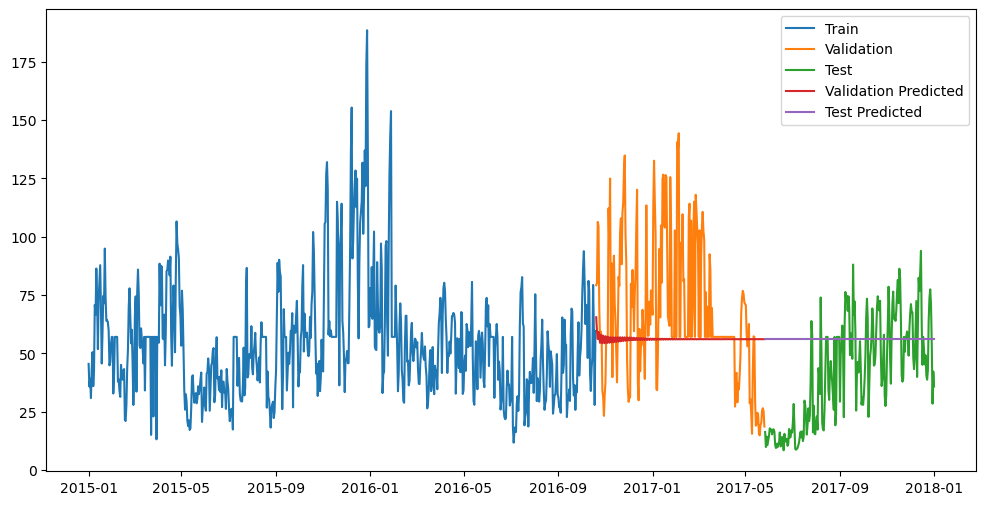

In [54]:
# Gerçek değerlerle tahmin edilen değerleri görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(train['NO2'], label='Train')
plt.plot(val['NO2'], label='Validation')
plt.plot(test['NO2'], label='Test')
plt.plot(val_predictionsNO2, label='Validation Predicted')
plt.plot(test_predictionsNO2, label='Test Predicted')
plt.legend()
plt.show()

In [55]:
best_modelNO2 = ARIMA(data['NO2'], order=(1, 1, 2))
model_fitNO2 = best_modelNO2.fit()
print(model_fitNO2.summary())  

                               SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                 1097
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -4616.477
Date:                Tue, 11 Jun 2024   AIC                           9240.954
Time:                        21:49:09   BIC                           9260.952
Sample:                    01-01-2015   HQIC                          9248.520
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5025      0.044     11.405      0.000       0.416       0.589
ma.L1         -0.7917      0.049    -16.132      0.000      -0.888      -0.695
ma.L2         -0.1302      0.038     -3.439      0.0

In [56]:
n_periods = 12  # 4 adım ileriye tahmin
forecastNO2 = model_fitNO2.forecast(steps=n_periods)
forecastNO2

2018-01-02    42.821574
2018-01-03    48.107659
2018-01-04    50.763719
2018-01-05    52.098289
2018-01-06    52.768861
2018-01-07    53.105798
2018-01-08    53.275096
2018-01-09    53.360162
2018-01-10    53.402905
2018-01-11    53.424381
2018-01-12    53.435172
2018-01-13    53.440594
Freq: D, Name: predicted_mean, dtype: float64

In [57]:
# Güven aralıklarını hesaplama
conf_intNO2 = model_fitNO2.get_forecast(steps=n_periods).conf_int()

In [58]:
# Tahminleri DataFrame'e çevirme
forecast_indexNO2 = pd.date_range(start=data.index[-1], periods=n_periods+1)
forecast_seriesNO2 = pd.Series(forecastNO2, index=forecast_indexNO2)
lower_seriesNO2 = pd.Series(conf_intNO2.iloc[:, 0], index=forecast_indexNO2)
upper_seriesNO2 = pd.Series(conf_intNO2.iloc[:, 1], index=forecast_indexNO2)

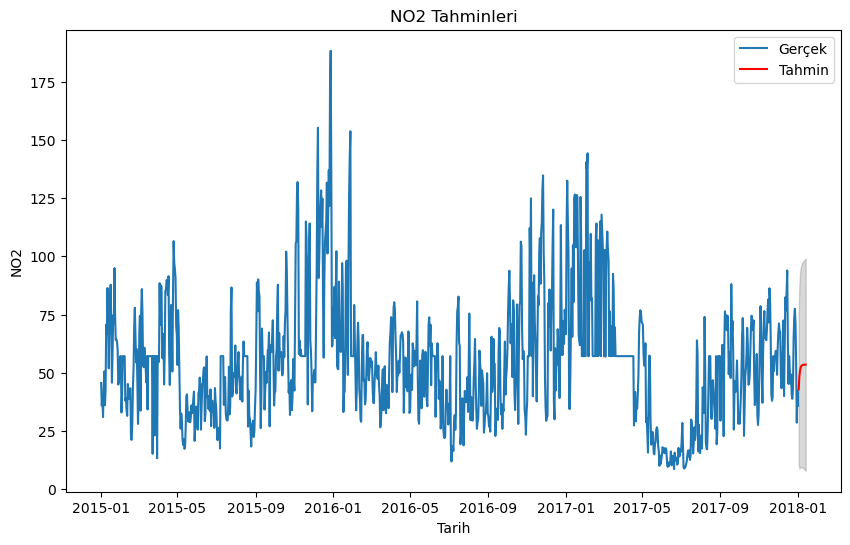

In [59]:
plt.figure(figsize=(10,6))
plt.plot(data.index, data['NO2'], label='Gerçek')
plt.plot(forecast_seriesNO2.index, forecast_seriesNO2, color='red', label='Tahmin')
plt.fill_between(lower_seriesNO2.index, 
                 lower_seriesNO2, 
                 upper_seriesNO2, 
                 color='k', alpha=.15)

plt.xlabel('Tarih')
plt.ylabel('NO2')
plt.title('NO2 Tahminleri')
plt.legend()
plt.show()

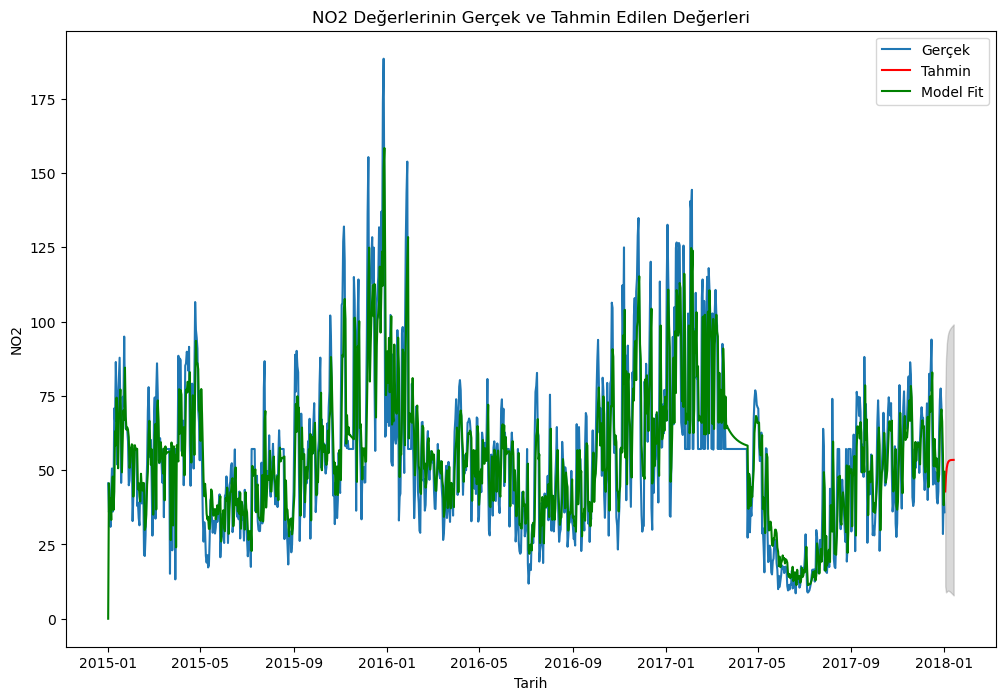

In [60]:
plt.figure(figsize=(12, 8))

plt.plot(data.index, data['NO2'], label='Gerçek')

# Model tarafından tahmin edilen veriler
plt.plot(forecast_seriesNO2.index, forecast_seriesNO2, color='red', label='Tahmin')
plt.fill_between(lower_seriesNO2.index, lower_seriesNO2, upper_seriesNO2, color='k', alpha=.15)

# Modelin eğitildiği dönem için tahmin değerleri
fitted_valuesNO2 = model_fitNO2.fittedvalues
plt.plot(fitted_valuesNO2.index, fitted_valuesNO2, color='green', label='Model Fit')

plt.xlabel('Tarih')
plt.ylabel('NO2')
plt.title('NO2 Değerlerinin Gerçek ve Tahmin Edilen Değerleri')
plt.legend()
plt.show()